In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt
from scipy.stats import norm
import time

In [2]:
pyro.enable_validation(True)

In [3]:
N = 10000
D = 10

In [4]:
def dgp(X):
#def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K = 7
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [5]:
trace = pyro.poutine.trace(dgp).get_trace(torch.zeros(N,D))
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['D', 'loc', 'scale', 'K', 'cov_factor', 'N', 'obs']

In [6]:
logp

tensor(-272705.8750)

In [7]:
_,true_loc,true_scale,_,true_cov_factor,_,data = true_variables

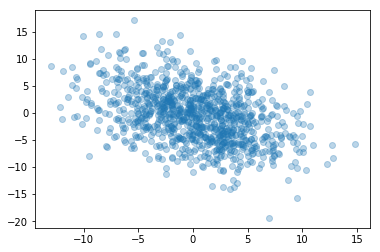

In [8]:
random_dims = np.random.choice(data.shape[1], size=2, replace=False)
random_dims.sort()
plt.scatter(*data.detach().numpy().T[random_dims,:1000],alpha=.3)

In [9]:
K = 3
#initial_hyperparameters = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
initial_hyperparameters = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)

In [10]:
#def model(X):
def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', size=N, subsample_size=N//1000) as ind:
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag), obs=data.index_select(0, ind))
    return X

In [11]:
def guide(X, hyperparameters):
#def guide(X):
    #K = 2
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D, dim=-1):
        # get initial parameter values from parent
        # define parameters, clone initial parameter values from supplied hyperparameters, to avoid updating them
        loc_loc = pyro.param('loc_loc', locloc)
        loc_scale = pyro.param('loc_scale', locscale, constraint=constraints.positive)
        cov_diag_loc = pyro.param('scale_loc', scaleloc)
        cov_diag_scale = pyro.param('scale_scale', scalescale, constraint=constraints.positive)
        # sample variables
        loc = pyro.sample('loc', dst.Normal(loc_loc,loc_scale))
        cov_diag = pyro.sample('scale', dst.LogNormal(cov_diag_loc, cov_diag_scale))
        with pyro.plate('K', K, dim=-2):
            cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(K), cov_factor_loc)
            cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(K), cov_factor_scale, constraint=constraints.positive)
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc, cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    return loc, cov_diag, cov_factor

In [12]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    #return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    return {"lr": 0.1, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [13]:
pyro.clear_param_store()

In [14]:
conditioned_model = model
#conditioned_model = pyro.condition(model, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.9})
#scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = Trace_ELBO()
#elbo = TraceMeanField_ELBO(vectorize_particles=True)
#elbo = TraceMeanField_ELBO()
svi = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=10)

In [15]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, initial_hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [16]:
start = time.time()
# optimize
#for i in range(20000):
i = 0
window = 300
gradients_are_decreasing = [True]
while i < 20000 and any(gradients_are_decreasing):
    loss = svi.step(data, initial_hyperparameters)
    if i % window or i <= window:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['loc_loc']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
        # check if gradients are trending downwards
        gradients_are_decreasing = []
        for name, gradient_norm in gradient_norms.items():
            recent = gradient_norm[-window:]
            # estimate slope by least squares
            m_hat = np.linalg.lstsq(np.vstack([np.arange(window), np.ones(window)]).T,recent, rcond=None)[0][0]
            # estimate standard deviation of losses in window
            s_hat = np.array(recent).std(ddof=2)
            # calculate probability that slope is less than 0
            P_negative_slope = norm.cdf(0,loc=m_hat,scale=12*s_hat**2/(window**3-window))
            # if it is more than .5, loss has been decreasing
            gradients_are_decreasing.append(P_negative_slope > .5)
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
    i += 1
end = time.time()
print('\nTraining took {} seconds'.format(round(end - start)))
params = pyro.get_param_store()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Setting lr to 0.09000000000000001
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.08100000000000002
...............................

In [17]:
i

4201

In [18]:
list(pyro.get_param_store().items())

[('loc_loc',
  tensor([-0.6394,  1.9422,  0.9656,  0.2688, -0.2584, -0.1602, -0.5177, -0.5885,
          -0.1213, -0.3978], requires_grad=True)),
 ('loc_scale',
  tensor([0.0428, 0.0475, 0.0317, 0.1029, 0.0828, 0.0222, 0.0429, 0.1151, 0.0265,
          0.0305], grad_fn=<AddBackward0>)),
 ('scale_loc',
  tensor([ 2.2968,  3.0882,  1.4895,  1.5701,  3.4706,  1.7728, -0.8620,  3.4419,
           0.6702,  2.1969], requires_grad=True)),
 ('scale_scale',
  tensor([0.0237, 0.0502, 0.0387, 0.0510, 0.0366, 0.0186, 0.3272, 0.0115, 0.0678,
          0.0307], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_3',
  tensor([[-0.5905,  2.8528, -1.9477, -3.4533, -0.4918, -0.9267,  3.0170,  1.2992,
           -2.0432,  0.4322],
          [-1.0725,  3.3786,  0.9243, -0.9396,  2.0071, -3.1622,  3.6566,  5.0737,
           -3.9854,  0.4473],
          [ 0.0818,  3.3637,  1.6728, -1.9456, -0.1462, -2.3839,  5.6552, -0.4757,
            2.8922,  4.1106]], requires_grad=True)),
 ('cov_factor_scale_3',
  tensor([[0

In [20]:
cov_loc_init = torch.randn(K+1,D)

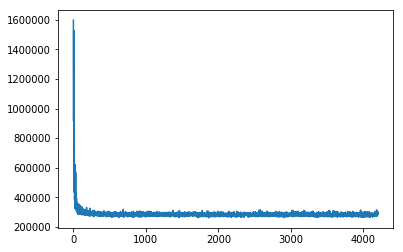

In [21]:
plt.plot(losses)

In [22]:
gradient_norms.keys()

dict_keys(['cov_factor_loc_3', 'cov_factor_scale_3', 'scale_loc', 'loc_loc', 'scale_scale', 'loc_scale'])

In [23]:
gradient_norms.keys()

dict_keys(['cov_factor_loc_3', 'cov_factor_scale_3', 'scale_loc', 'loc_loc', 'scale_scale', 'loc_scale'])

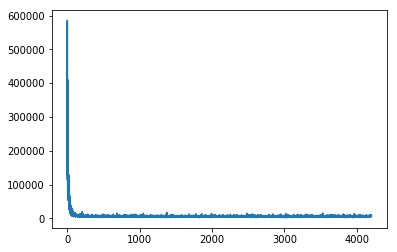

In [24]:
plt.plot(gradient_norms['scale_loc'])

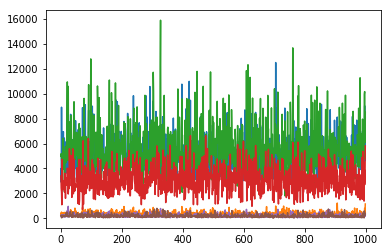

In [52]:
plt.plot(np.array(list(gradient_norms.values()))[:,-1000:].T)

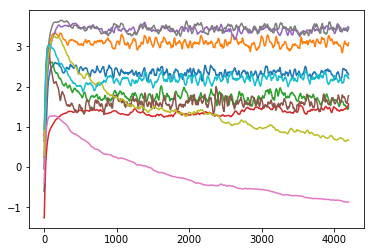

In [26]:
plt.plot(param_history['scale_loc'].detach().numpy())

In [27]:
true_scale

tensor([ 3.0866,  1.2163,  0.0940,  2.8571, 11.5558,  0.5394,  0.5992,  0.2026,
         4.5026,  5.4345])

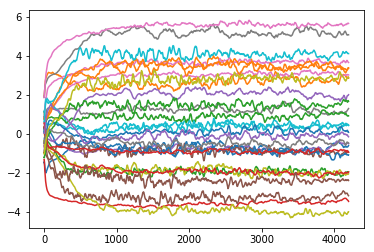

In [28]:
plt.plot(param_history['cov_factor_loc_3'].reshape(-1,K*D).detach().numpy());

In [29]:
# MAP
est_cov_factor = pyro.param('cov_factor_loc_{}'.format(K))
est_diag = dst.LogNormal(params.get_param('scale_loc'),params.get_param('scale_scale')).mean

In [30]:
# EXPECTED COVARIANCE AND CORRELATION
#true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
print(true_total_cov)
invsds = torch.diag(torch.sqrt(torch.diag(true_total_cov))).inverse()
# expected correlation matrix
torch.matmul(invsds,torch.matmul(true_total_cov,invsds))

tensor([[ 11.5415,  -8.4117,  -0.8413,   2.2828,   6.3922,   1.0048,  -4.4702,
          -2.4007,   5.8877,  -2.8223],
        [ -8.4117,  51.1132,   0.5356, -16.3065,  -1.2619, -20.9431,  38.5288,
          24.6446,  -7.4721,  22.0219],
        [ -0.8413,   0.5356,  11.9527,   3.0327,   1.1509,  -4.4098,   5.7743,
           5.0608,   3.9027,   6.5768],
        [  2.2828, -16.3065,   3.0327,  20.3918,   2.1200,   9.8288, -23.7612,
          -9.8759,   4.2079,  -8.7728],
        [  6.3922,  -1.2619,   1.1509,   2.1200,  34.8131,  -6.1872,   5.3160,
           6.6920,  -7.6115,  -3.7076],
        [  1.0048, -20.9431,  -4.4098,   9.8288,  -6.1872,  21.3038, -26.7508,
         -17.4561,   7.1112,  -9.1862],
        [ -4.4702,  38.5288,   5.7743, -23.7612,   5.3160, -26.7508,  52.0899,
          17.8360,  -4.0759,  24.4412],
        [ -2.4007,  24.6446,   5.0608,  -9.8759,   6.6920, -17.4561,  17.8360,
          57.7303, -23.4275,   1.2445],
        [  5.8877,  -7.4721,   3.9027,   4.2079,

tensor([[ 1.0000, -0.3463, -0.0716,  0.1488,  0.3189,  0.0641, -0.1823, -0.0930,
          0.3192, -0.1656],
        [-0.3463,  1.0000,  0.0217, -0.5051, -0.0299, -0.6347,  0.7467,  0.4537,
         -0.1925,  0.6139],
        [-0.0716,  0.0217,  1.0000,  0.1943,  0.0564, -0.2764,  0.2314,  0.1927,
          0.2079,  0.3791],
        [ 0.1488, -0.5051,  0.1943,  1.0000,  0.0796,  0.4716, -0.7291, -0.2878,
          0.1716, -0.3872],
        [ 0.3189, -0.0299,  0.0564,  0.0796,  1.0000, -0.2272,  0.1248,  0.1493,
         -0.2376, -0.1252],
        [ 0.0641, -0.6347, -0.2764,  0.4716, -0.2272,  1.0000, -0.8030, -0.4978,
          0.2838, -0.3966],
        [-0.1823,  0.7467,  0.2314, -0.7291,  0.1248, -0.8030,  1.0000,  0.3253,
         -0.1040,  0.6749],
        [-0.0930,  0.4537,  0.1927, -0.2878,  0.1493, -0.4978,  0.3253,  1.0000,
         -0.5680,  0.0326],
        [ 0.3192, -0.1925,  0.2079,  0.1716, -0.2376,  0.2838, -0.1040, -0.5680,
          1.0000,  0.3387],
        [-0.1656,  

In [31]:
# EMPIRICAL COVARIANCE AND CORRELATION
print(np.cov(data.detach().numpy().T))
#empirical correlation matrix
np.corrcoef(data.detach().numpy().T)

[[ 11.52110505  -8.78185669  -0.75260724   2.50340379   6.03550363
    1.15445031  -4.76347575  -2.70375      6.13853996  -2.97256742]
 [ -8.78185669  52.33417252   0.18429865 -17.15784805  -1.61358843
  -21.44607588  39.52680796  26.15825846  -8.47748739  22.33695267]
 [ -0.75260724   0.18429865  12.03415355   3.06543011   1.37536622
   -4.32183748   5.68294894   4.85391938   3.99866987   6.56158385]
 [  2.50340379 -17.15784805   3.06543011  20.60343631   2.55650878
   10.32104189 -24.44445738 -10.49967225   4.59494257  -9.1314568 ]
 [  6.03550363  -1.61358843   1.37536622   2.55650878  34.62481831
   -5.90997313   4.83372749   6.40235912  -7.22224893  -3.7137586 ]
 [  1.15445031 -21.44607588  -4.32183748  10.32104189  -5.90997313
   21.52656634 -27.37805075 -17.84967279   7.37818276  -9.53328157]
 [ -4.76347575  39.52680796   5.68294894 -24.44445738   4.83372749
  -27.37805075  53.22031915  18.89287052  -4.62622221  24.91382121]
 [ -2.70375     26.15825846   4.85391938 -10.49967225  

array([[ 1.        , -0.35764042, -0.06391658,  0.16248527,  0.30218486,
         0.07330621, -0.19237036, -0.1037237 ,  0.33183946, -0.17395124],
       [-0.35764042,  1.        ,  0.00734381, -0.52251686, -0.03790586,
        -0.63895133,  0.74896293,  0.47084143, -0.21502278,  0.61330163],
       [-0.06391658,  0.00734381,  1.        ,  0.19467663,  0.0673778 ,
        -0.26851792,  0.22455733,  0.18219788,  0.21150361,  0.37570224],
       [ 0.16248527, -0.52251686,  0.19467663,  1.        ,  0.09571582,
         0.49007927, -0.73819625, -0.30120657,  0.18574634, -0.39958862],
       [ 0.30218486, -0.03790586,  0.0673778 ,  0.09571582,  1.        ,
        -0.21647332,  0.11260293,  0.14167878, -0.22521054, -0.1253611 ],
       [ 0.07330621, -0.63895133, -0.26851792,  0.49007927, -0.21647332,
         1.        , -0.80886567, -0.5009581 ,  0.29179109, -0.40812943],
       [-0.19237036,  0.74896293,  0.22455733, -0.73819625,  0.11260293,
        -0.80886567,  1.        ,  0.33722343

In [32]:
# MAP COVARIANCE AND CORRELATION
est_total_cov = est_cov_factor.transpose(0,1) @ est_cov_factor + torch.diag(est_diag)
print(est_total_cov)
est_invsds = torch.diag(torch.sqrt(torch.diag(est_total_cov))).inverse()
est_corr_mat = torch.matmul(est_invsds,torch.matmul(est_total_cov,est_invsds))
print(est_corr_mat)

tensor([[ 11.4505,  -5.0331,   0.2957,   2.8878,  -1.8742,   3.7437,  -5.2408,
          -6.2478,   5.7175,  -0.3987],
        [ -5.0331,  52.8339,   3.1930, -19.5706,   4.8862, -21.3461,  39.9836,
          19.2485,  -9.5654,  16.5713],
        [  0.2957,   3.1930,  11.8840,   2.6030,   2.5683,  -5.1056,   6.9632,
           1.3634,   5.1337,   6.4477],
        [  2.8878, -19.5706,   2.6030,  21.4069,   0.0969,  10.8093, -24.8572,
          -8.3285,   5.1733,  -9.9105],
        [ -1.8742,   4.8862,   2.5683,   0.0969,  36.4694,  -5.5424,   5.0284,
           9.6138,  -7.4171,   0.0842],
        [  3.7437, -21.3461,  -5.1056,  10.8093,  -5.5424,  22.4293, -27.8401,
         -16.1140,   7.6012, -11.6145],
        [ -5.2408,  39.9836,   6.9632, -24.8572,   5.0284, -27.8401,  54.8999,
          19.7824,  -4.3815,  26.1861],
        [ -6.2478,  19.2485,   1.3634,  -8.3285,   9.6138, -16.1140,  19.7824,
          58.9056, -24.2505,   0.8760],
        [  5.7175,  -9.5654,   5.1337,   5.1733,

In [33]:
from hinton import *

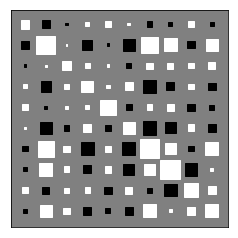

In [34]:
hinton(true_total_cov)

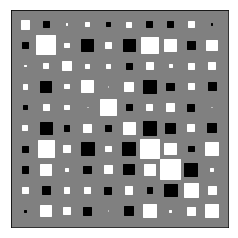

In [35]:
hinton(est_total_cov.detach().numpy())

In [85]:
from tracepredictive import *
svi2 = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=1000)
trace_pred = TracePredictive(model, svi2, num_samples=1000).run(data, initial_hyperparameters)
random_idx = np.random.randint(10)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

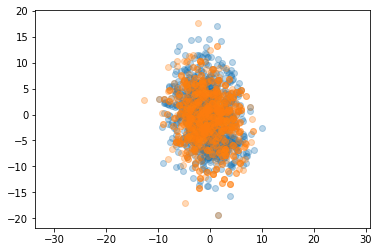

In [94]:
random_dims = np.random.choice(data.shape[1], size=2, replace=False)
random_dims.sort()
plt.scatter(*data.detach().numpy().T[random_dims,:1000],alpha=.3)
#plt.axis('equal');
#plt.figure()
plt.scatter(*predictive_dst_sample.detach().numpy().T[random_dims],alpha=.3);
plt.axis('equal');

In [95]:
true_cov_factor.transpose(0,1)

tensor([[ 1.7536, -0.5274, -0.4318,  0.7151,  1.4054,  1.0864, -1.1174],
        [-1.8241, -1.3063, -0.6619, -2.2183,  2.0460, -5.8591,  0.9944],
        [ 0.9189,  0.2712,  0.7685,  2.4933, -0.9655, -1.7254,  0.4739],
        [ 0.4977, -0.9918,  3.0310,  1.4421, -0.0945,  2.0730,  0.8548],
        [-0.9816,  0.6039, -0.4432,  2.7959,  3.6610,  0.5865, -0.4108],
        [ 1.2166,  1.8021,  2.2540, -1.4431, -0.7181,  2.8792,  0.2613],
        [-0.7314,  0.4282, -4.2226,  0.3941,  1.3536, -5.4907,  0.8983],
        [-2.7641, -0.3966,  1.1280,  0.9566,  0.6734, -4.4047, -5.2619],
        [ 4.6398, -0.3305,  0.0484, -0.4067, -0.3078,  0.2402,  1.7359],
        [ 1.5340,  0.2920, -0.8574, -0.4111,  0.3399, -3.6313,  1.7604]])

In [96]:
est_cov_factor

tensor([[-0.5905,  2.8528, -1.9477, -3.4533, -0.4918, -0.9267,  3.0170,  1.2992,
         -2.0432,  0.4322],
        [-1.0725,  3.3786,  0.9243, -0.9396,  2.0071, -3.1622,  3.6566,  5.0737,
         -3.9854,  0.4473],
        [ 0.0818,  3.3637,  1.6728, -1.9456, -0.1462, -2.3839,  5.6552, -0.4757,
          2.8922,  4.1106]], requires_grad=True)